In [21]:


#https://www.tensorflow.org/tutorials/keras/keras_tuner
#https://keras.io/guides/keras_tuner/getting_started/
# https://keras.io/api/keras_tuner/tuners/bayesian/ 

#https://www.analyticsvidhya.com/blog/2021/08/hyperparameter-tuning-of-neural-networks-using-keras-tuner/

import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime # Date Functions
import time
import math


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.keras.utils import data_utils


from google.cloud import bigquery

print(tf.__version__)

2.11.0


In [22]:
cateCols=['sla','product_type','brand','service_type','incident_type']

numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']


labelCol='label_multi_severity'


# Load data from BigQuery
projectId='pongthorn'
dataset_id='DemoSMartDW'
 

# Load Data

In [23]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 return df

def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 return df

In [24]:
train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

In [25]:


train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"{train_table_id} - {val_tabel_id} - {test_tabel_id}")

client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

# Load data from CSV File
# root_path='../../data'    
# train = load_ml_data(f"{root_path}/{train_name}.csv")
# val=load_ml_data(f"{root_path}/{validation_name}.csv")
# test =load_ml_data(f"{root_path}/{test_name}.csv")

print(train.shape)
print(val.shape)
print(test.shape)


pongthorn.DemoSMartDW.train_incident - pongthorn.DemoSMartDW.validation_incident - pongthorn.DemoSMartDW.test_incident
(1814, 8)
(227, 8)
(227, 8)


In [26]:

labelList=list(train[labelCol].unique())
print("List All Label:" ,sorted(labelList))
nLabel=len(labelList)
print(f"No target label : {nLabel}")
                 
print(train.info())
train.sample(10)

List All Label: [0, 1, 2, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1814 non-null   object 
 1   product_type               1814 non-null   object 
 2   brand                      1814 non-null   object 
 3   service_type               1814 non-null   object 
 4   incident_type              1814 non-null   object 
 5   open_to_close_hour         1814 non-null   float64
 6   response_to_resolved_hour  1814 non-null   float64
 7   label_multi_severity       1814 non-null   Int64  
dtypes: Int64(1), float64(2), object(5)
memory usage: 115.3+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
1270,24x7 4Hrs Resolution Time,Storage,Oracle,Incident,Hard Disk Drive Failure,2.000000,2.000000,2
1764,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,General Incident,0.616667,0.416667,2
214,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,7.950000,7.783333,2
1433,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,10.316667,10.000000,2
1736,24x7 4Hrs Response Time,Other,Veritas,Incident,Backup Failure,67.800000,67.333333,1
1204,24x7 4Hrs Resolution Time,Server,Oracle,Incident,General Incident,6.383333,6.266667,2
876,24x7 6Hrs Resolution Time,Storage,NetApp,Incident,Network Card Failure,17.666667,17.566667,2
1008,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,34.283333,34.016667,1
981,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,0.800000,0.500000,1
787,24x7 4Hrs Resolution Time,Switch,Cisco,Incident,General Incident,1147.216667,403.066667,1


In [27]:
# Percentage of each severity
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,323,18.0,50,22.0,39,17.0
1,529,29.0,63,28.0,68,30.0
2,876,48.0,101,44.0,109,48.0
3,86,5.0,13,6.0,11,5.0


# Process Data  Layer

In [28]:
# dataframe to  tf.data
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [29]:
# Tensorflow format
print("Explore Data from Tensor before keras data processing")
batch_size = 3  # list 3 sample data
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])  # sample cate feature
print('open_to_close_hour:', train_features['open_to_close_hour'])  # sample numberic feature
print("========Labels==========")
print(f'{label_batch }')

Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Software' b'Server' b'Software'], shape=(3,), dtype=string)
open_to_close_hour: tf.Tensor([  2.           9.48333333 121.41666667], shape=(3,), dtype=float64)
========Labels==========
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [30]:
# Normalizaton and categorical Endcoding

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [31]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [32]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)




In [33]:
all_inputs = []
encoded_features = []
numInputFeatToInitNodeUnit=0

# Numeric features.
for header in numbericCols:
  stat_data=train[header].describe()
  print(f"{header}: Mean={stat_data['mean']} and Std={stat_data['std']}")  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
    
numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)
    
    # Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow
    
  print(f"{header} = {noCateItem} : {listCateItem}")

  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


print(f"Total column to initialize first node input: {numInputFeatToInitNodeUnit}")

open_to_close_hour: Mean=96.70577912532157 and Std=264.30857031412927
response_to_resolved_hour: Mean=69.23291988239617 and Std=210.15946331055562
sla = 7 : ['24x7 4Hrs Resolution Time' '8x5 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '24x7 4Hrs Response Time'
 '9x5xNBD 4Hrs Response Time' '24x7 6Hrs Response Time' 'Non MA']
sla
product_type = 10 : ['Server' 'Software' 'Other' 'Firewall' 'Hardware' 'Storage' 'Switch'
 'Access Point' 'Security' 'Tape Library']
product_type
brand = 23 : ['IBM' 'Microsoft' 'F5' 'Nutanix' 'CheckPoint' 'Broadcom' 'CIMCO-CMMS'
 'eUnite' 'Fortinet' 'EMC' 'HPE' 'YIP' 'DELL' 'Cisco' 'SAPB1' 'Veeam'
 'NetApp' 'Oracle' 'VMWare' 'Red Hat' 'Veritas' 'Palo Alto' 'Trend Micro']
brand
service_type = 2 : ['Incident' 'Request']
service_type
incident_type = 21 : ['Hard Disk Drive Failure' 'General Incident' 'Software'
 'Network Cable Failure' 'Maintenance System' 'Upgrade Software'
 'Network Adapter Failure' 'Report' 'Memory Failure'
 'System Board Failure' 'Control

# Tune HyperParameter By Keras Tuner

In [36]:
seed=1932

EPOCHS =100
BATCH_SIZE = 32
unitList=[16,32,64,numInputFeatToInitNodeUnit]


dropOutList= [0.1, 0.2]

print(f"All possible combination {len(unitList)}x{len(dropOutList)}={ len(unitList) * len(dropOutList)}")



All possible combination 4x2=8


In [37]:
nMax_trials=5 # default
nExecutions_per_trial=3
nEarlyPatience=5

model_tuned_dir='model_tuned'

In [38]:
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

tune_folder="IncidentMLP"

In [39]:
t_Start=time.time()

print(f"Start tund at {datetime.now()}")
print("=============================================================")
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{tune_folder}_{buildtime}"
print(project_model)

Start tund at 2023-04-13 23:22:03.926686
IncidentMLP_130423_2322


In [40]:
def build_model_for_tuning(hp):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(hp.Choice('units', unitList), activation="relu")(all_features)
    
    x = tf.keras.layers.Dropout(hp.Choice('Dropout_rate',dropOutList))(x)
    
    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)
    
    model = tf.keras.Model(all_inputs, output)
    model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    
    return model

In [41]:
objective_name='val_accuracy'  # valloss
tuner = kt.BayesianOptimization(
## tuner = kt.Hyperband(
# tuner = keras_tuner.RandomSearch(  #main_objective
    build_model_for_tuning, objective=objective_name,seed=seed,
    max_trials=nMax_trials,executions_per_trial=nExecutions_per_trial,
    directory=f"tuning/{tune_folder}/",project_name= project_model)

stop_early = tf.keras.callbacks.EarlyStopping(monitor=objective_name, patience=nEarlyPatience)
tuner.search(train_ds, batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=val_ds,callbacks=[stop_early])
    

Trial 5 Complete [00h 00m 23s]
val_accuracy: 0.7650514046351115

Best val_accuracy So Far: 0.7650514046351115
Total elapsed time: 00h 01m 53s
INFO:tensorflow:Oracle triggered exit


In [47]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units': 70, 'Dropout_rate': 0.2}


# Retain by best model to product model to get max Epoch

In [48]:
print("Build the model with the optimal hyperparameters and train it on the data to find  N epochs")
best_model = tuner.hypermodel.build(best_hps)
# model.summary()
history = best_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)


Build the model with the optimal hyperparameters and train it on the data to find  N epochs
Epoch 1/100
57/57 [==============================] - 2s 14ms/step - loss: 1.2586 - accuracy: 0.4234 - val_loss: 1.0860 - val_accuracy: 0.5198
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 0.9799 - accuracy: 0.5915 - val_loss: 0.9349 - val_accuracy: 0.6520
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 0.8539 - accuracy: 0.6687 - val_loss: 0.8377 - val_accuracy: 0.7093
Epoch 4/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7813 - accuracy: 0.6940 - val_loss: 0.7939 - val_accuracy: 0.7137
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7560 - accuracy: 0.6896 - val_loss: 0.7796 - val_accuracy: 0.6916
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7398 - accuracy: 0.6918 - val_loss: 0.7654 - val_accuracy: 0.7048
Epoch 7/100
57/57 [==============================] - 0s 5ms/s

In [49]:
val_acc_per_epoch = history.history[objective_name]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Best epoch: 61


In [50]:
print("Take Optimal Best Epoch  by Re-instantiating the hypermodel and train it")
model = tuner.hypermodel.build(best_hps)
# Retrain the model to get final
history_hypermodel=model.fit(train_ds, validation_data=val_ds, epochs=best_epoch)

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Eveluation on Val-Data at {best_epoch} epochs : loss={val_loss} and accuracy= {val_accuracy}")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Evaluation on Test-Data at {best_epoch} epochs : loss={test_loss} and accuracy= {test_accuracy}")

Take Optimal Best Epoch  by Re-instantiating the hypermodel and train it
Epoch 1/61
57/57 [==============================] - 3s 15ms/step - loss: 1.1705 - accuracy: 0.5088 - val_loss: 1.0545 - val_accuracy: 0.5595
Epoch 2/61
57/57 [==============================] - 0s 4ms/step - loss: 0.9500 - accuracy: 0.6207 - val_loss: 0.9102 - val_accuracy: 0.6960
Epoch 3/61
57/57 [==============================] - 0s 4ms/step - loss: 0.8410 - accuracy: 0.6604 - val_loss: 0.8324 - val_accuracy: 0.6960
Epoch 4/61
57/57 [==============================] - 0s 5ms/step - loss: 0.7833 - accuracy: 0.6659 - val_loss: 0.7956 - val_accuracy: 0.7269
Epoch 5/61
57/57 [==============================] - 0s 5ms/step - loss: 0.7522 - accuracy: 0.6775 - val_loss: 0.7764 - val_accuracy: 0.7093
Epoch 6/61
57/57 [==============================] - 0s 5ms/step - loss: 0.7364 - accuracy: 0.6891 - val_loss: 0.7614 - val_accuracy: 0.7401
Epoch 7/61
57/57 [==============================] - 0s 5ms/step - loss: 0.7149 - accur

4#Explore Result model


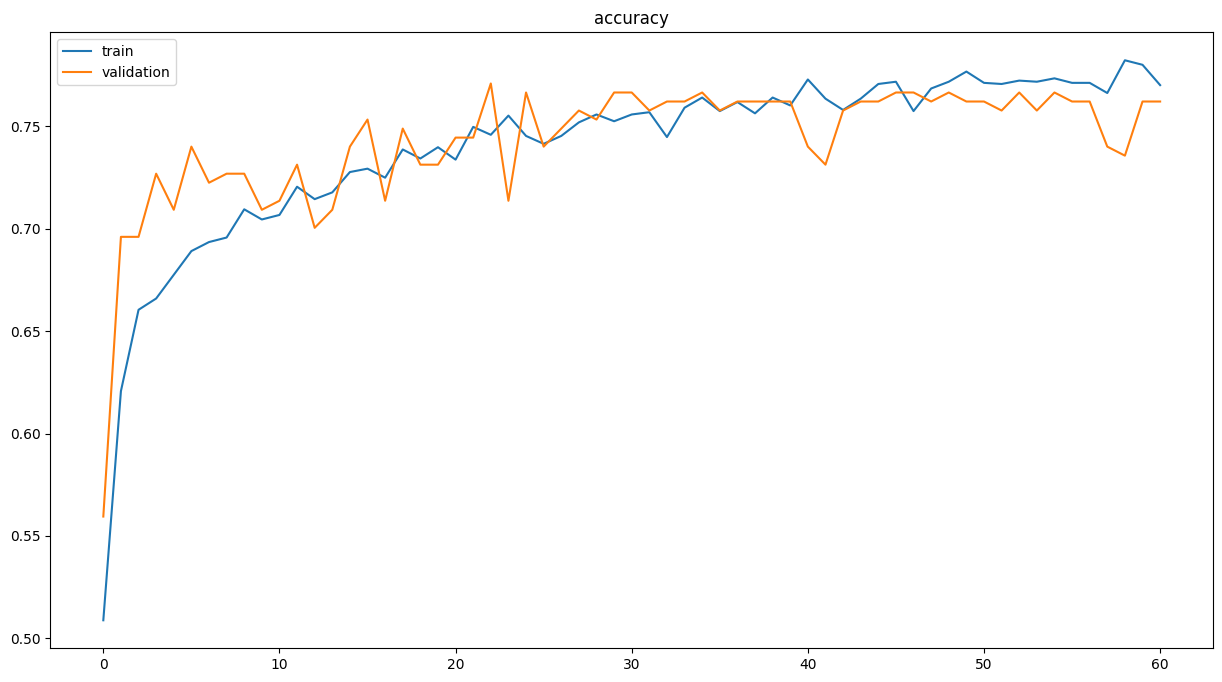

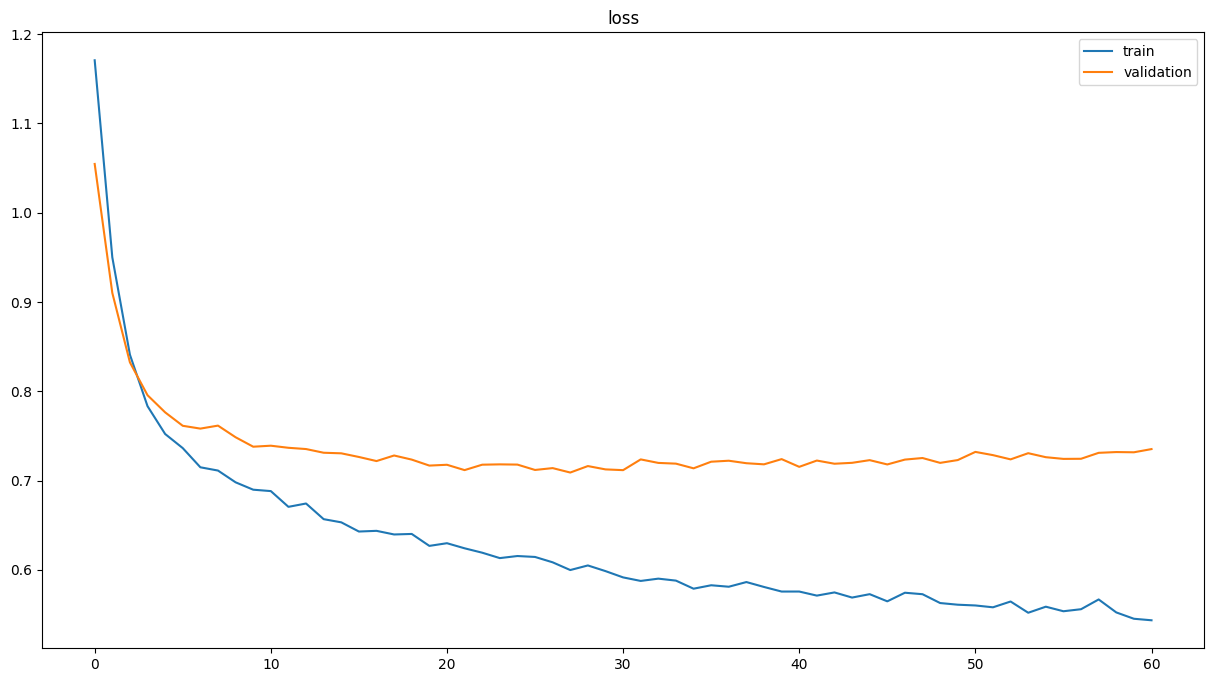

In [54]:
def plot_metrics(history,metric):
    plt.figure(figsize=(15,8))
    plt.title(metric)
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.legend()
    plt.show() 

print("4#Explore Result model")
plot_metrics(history_hypermodel,'accuracy')
plot_metrics(history_hypermodel,"loss")

# Save Model

In [56]:
model.save(model_tuned_dir)


INFO:tensorflow:Assets written to: model_tuned\assets


INFO:tensorflow:Assets written to: model_tuned\assets


# Copy Model From Local To GCS For Cloud Function To Invoke Model

In [62]:
MODEL_BUCKET = f'gs://demo-tuned-tf-incident-{projectId}'
REGION='asia-southeast1'

In [63]:
!gsutil mb -l $REGION $MODEL_BUCKET

Creating gs://demo-tuned-tf-incident-pongthorn/...


In [64]:
!gsutil -m cp -r ./$model_tuned_dir/* $MODEL_BUCKET/$model_tuned_dir



Copying file://.\model_tuned\keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://.\model_tuned\saved_model.pb [Content-Type=application/octet-stream]...
Copying file://.\model_tuned\fingerprint.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/514.0 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/514.0 KiB]   0% Done                                    
Copying file://.\model_tuned\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/514.0 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/514.0 KiB]   0% Done                                    
Copying file://.\model_tuned\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/514.0 KiB]   0% Done                                    
/ [1/5 files][ 38.8 KiB/514.0 KiB]   7% Done                                    
/ [2/5 files][ 38.8 KiB/514.0 KiB]   7% 